# Introduction
Crime data is a valuable source to make informed decision that improve personal safety. The data used in this analysis contains important attributes including the time, location, category and resolution of incidents that occured in San Francisco during Summer 2014.

For this analysis, the data will be used to determine the safest district. Judging by merley the incidents count in a district could be naive because it will assume equal weight for all incidents. Such naive analysis assumes that all crimes have the same threat level which is not true giving the crime category information in the dataset.

Therefore, here we define a threat-level indicator that assign different weight to different crimes. The indicator also takes into account the incident resolution which is necessary since the level of law enforcement can vary between districts.

This notebook starts by loading, exploring and cleaning the data. Next, the threat-level indicator will be formulated which is used to compare the safety level between districts.

### Load San Francisco Crime Data For Summer 2014

In [56]:
library(curl)
data <- read.csv(curl("https://raw.githubusercontent.com/uwescience/datasci_course_materials/master/assignment6/sanfrancisco_incidents_summer_2014.csv"))

# Explore The Data

### Check the structure of the data
It is useful to see what columns exist in the dataset

In [21]:
head(data,3)

,IncidntNum,Category,Descript,DayOfWeek,Date,Time,PdDistrict,Resolution,Address,X,Y,Location,PdId
1,140734311,ARSON,ARSON OF A VEHICLE,Sunday,08/31/2014,23:50,BAYVIEW,NONE,LOOMIS ST / INDUSTRIAL ST,-122.4056,37.73832,"(37.7383221869053, -122.405646994567)",1.407343e+13
2,140736317,NON-CRIMINAL,LOST PROPERTY,Sunday,08/31/2014,23:45,MISSION,NONE,400 Block of CASTRO ST,-122.435,37.76177,"(37.7617677182954, -122.435012093789)",1.407363e+13
3,146177923,LARCENY/THEFT,GRAND THEFT FROM LOCKED AUTO,Sunday,08/31/2014,23:30,SOUTHERN,NONE,1000 Block of MISSION ST,-122.4098,37.78004,"(37.7800356268394, -122.409795194505)",1.461779e+13


### Frequency of different crime categories
Crime categories is an interesting column, let's explore the frequency of each crime type

In [48]:
as.data.frame(table(Category=data$Category))

,Category,Freq
1,ARSON,63
2,ASSAULT,2882
3,BRIBERY,1
4,BURGLARY,6
5,DISORDERLY CONDUCT,31
6,DRIVING UNDER THE INFLUENCE,100
7,DRUG/NARCOTIC,1345
8,DRUNKENNESS,147
9,EMBEZZLEMENT,10
10,EXTORTION,7


### Remove non-criminal records
It seems that not all records represent crime activity. For example, when a lost item is found and returned, it can be categoriezed as NON-CRIMINAL incidents, which is clearly should be removed from the analysis. 

In [61]:
data <- data[data$Category != 'NON-CRIMINAL',]

### Frequency of different crime resolution

In [62]:
as.data.frame(table(Resolution=data$Resolution))

,Resolution,Freq
1,"ARREST, BOOKED",6361
2,"ARREST, CITED",1405
3,CLEARED-CONTACT JUVENILE FOR MORE INFO,7
4,COMPLAINANT REFUSES TO PROSECUTE,54
5,DISTRICT ATTORNEY REFUSES TO PROSECUTE,19
6,EXCEPTIONAL CLEARANCE,38
7,JUVENILE ADMONISHED,24
8,JUVENILE BOOKED,158
9,JUVENILE CITED,90
10,JUVENILE DIVERTED,5


## Visualizing Crime Frequency per District

### Naive analysis of total crime count per district
It is useful to visualize total crime count per district. However, it is naive because it does not take into account unresolved crimes which will be visualized next. Importantly, it does not consider population size of each district due to lack of data on population size for all districts. If such data exists, all counts should be scaled by population size to provide a better indication. **The assumption here is that districts have similar population size**

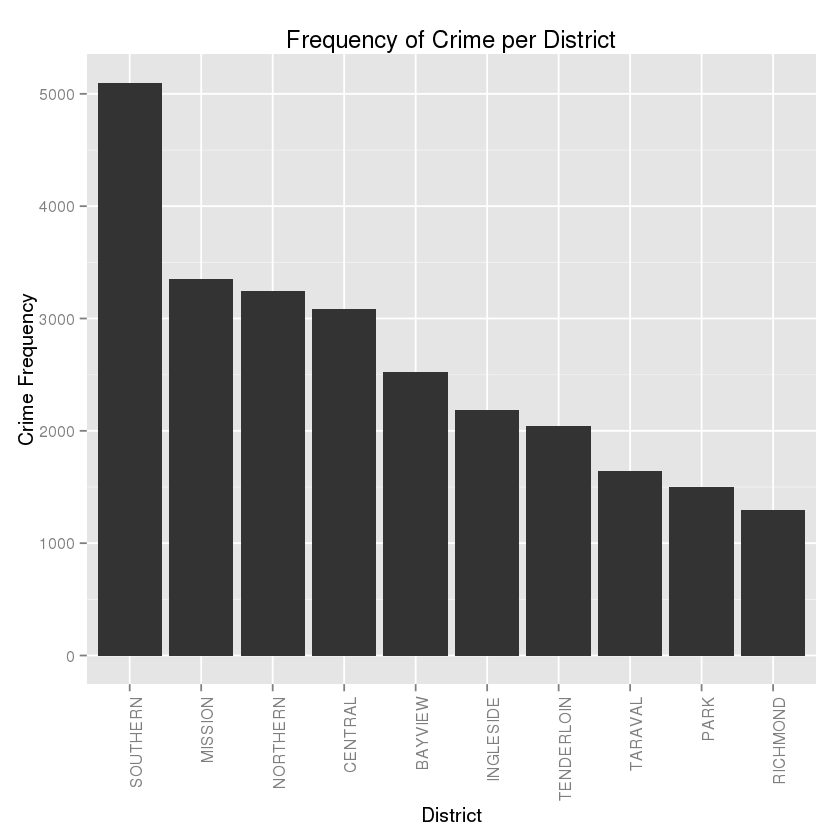

In [54]:
library(ggplot2)
district.crime <- as.data.frame(table(District=data$PdDistrict))
ggplot(district.crime,aes(reorder(District,-Freq),Freq)) + geom_bar(stat="identity", position="dodge") + 
       theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
       xlab("District") +
       ylab("Crime Frequency") +
       ggtitle("Frequency of Crime per District")

### Only consider unresolved crimes

A better indication of safety is to take into consideration the law enforcement effort to reduce crimes. Here is the same plot but for only unresolved crimes.

When compared to the previous figure, this is a better indicator for safety than the simple total count. For example, Mission district should as the 2nd highest crime frequency, but here it is the 4th highest. This could be due to a better law enforcement effort to resolve larger number of crimes.

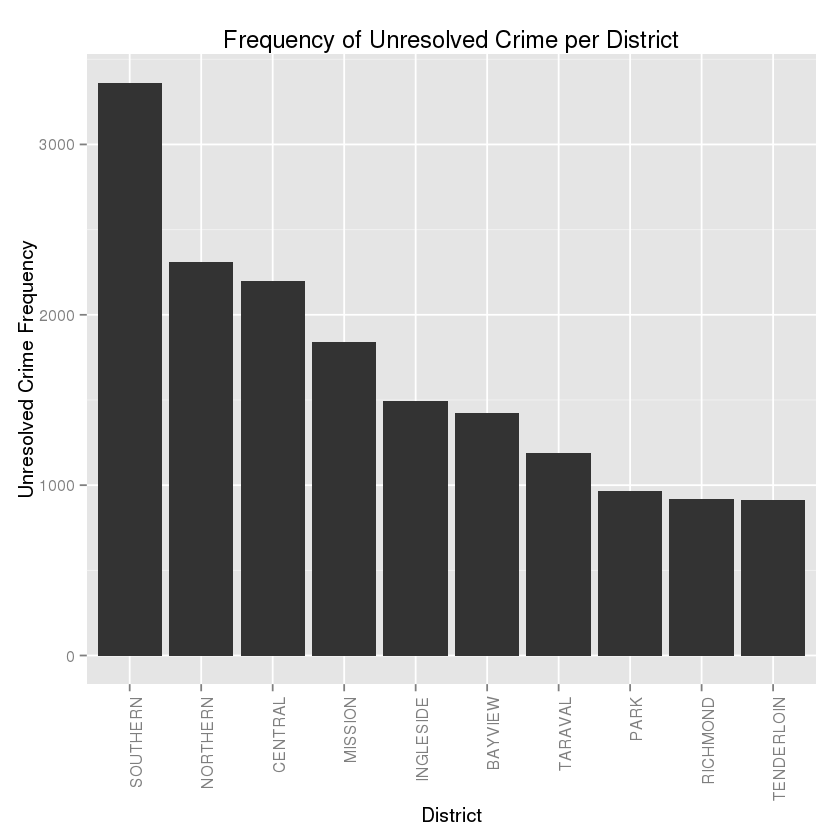

In [63]:
library(ggplot2)
data.arrest <- data[data$Resolution == 'NONE',]
district.crime <- as.data.frame(table(District=data.arrest$PdDistrict))
ggplot(district.crime,aes(reorder(District,-Freq),Freq)) + geom_bar(stat="identity", position="dodge") + 
       theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
       xlab("District") +
       ylab("Unresolved Crime Frequency") +
       ggtitle("Frequency of Unresolved Crime per District")

# Developing a Threat-Level Indicator

As mentioned earlier, just using crime count might not be a sufficient indicator to the threat level because it assumes that all crimes have the same weight. To formulate a threat-level indicator for each incident, we can assign a weight that represent the threat-level of each incident category.

For simplicity three threat-levels are considered here equivilant to the weight value of 0.5, 1 and 1.5

In [66]:
# Default threat of 1 can be interpreted as medium level.
data$Threat <- 1

# Categories with low threat
low.threat <- c("BRIBERY","DISORDERLY CONDUCT","FAMILY OFFENSES","FORGERY/COUNTERFEITING","FRAUD"
               ,"GAMBLING","LOITERING","OTHER OFFENSES"
               ,"RUNAWAY","SECONDARY CODES","SUICIDE","SUSPICIOUS OCC")

# Categories with low threat
high.threat <- c("ARSON","ASSAULT","BURGLARY","EXTORTION","KIDNAPPING","ROBBERY","VANDALISM","VEHICLE THEFT")

Update the *Threat* level value based on the incident category. For low threat crimes the weight is 0.5 while for high threat crimes the weight is 1.5

The default weight is 1, but after calculating the weight all unresolved crimes will be multiplied by 1.5 to take into account the level of law enforcement effort in resolving crimes.

In [100]:
for(level in low.threat){
    data[data$Category == level,]$Threat <- 0.5
}

for(level in high.threat){
    data[data$Category == level,]$Threat <- 1.5
}

data[data$Resolution == "NONE",]$Threat <-  data[data$Resolution == "NONE",]$Threat * 1.5

Finally, after calculating the threat indicator, the total sum per district will be computed to produce the final plot.

In [101]:
threat.level <-aggregate(Threat ~ PdDistrict , data, sum)

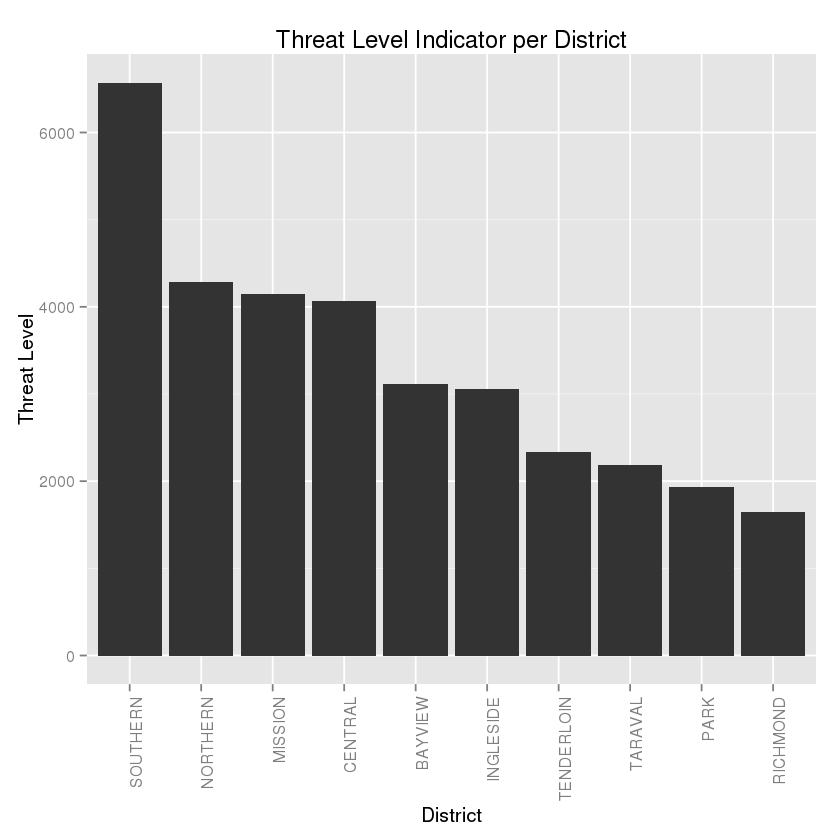

In [102]:
library(ggplot2)
ggplot(threat.level,aes(reorder(PdDistrict,-Threat),Threat)) + geom_bar(stat="identity", position="dodge") + 
       theme(axis.text.x = element_text(angle = 90, hjust = 1)) +
       xlab("District") +
       ylab("Threat Level") +
       ggtitle("Threat Level Indicator per District")

# Conclusion

The threat level indicator developed here aims to provide a better safety indicator for districts. The analysis indicates that Richmond district has the best safety indicator value. Once again, the assumption here is that all districts have similar population size, otherwise all data needs to be scaled by the population size.